# Fourth Task: Prediction

### Import of the needed libraries and the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import pydotplus 
from IPython.display import Image  
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

cyclists = pd.read_csv('./dataset/cyclists_trasformed.csv')
races = pd.read_csv('./dataset/races_trasformed.csv')

# Data Preparation

Before employing the learning algorithms, we need to perform a few adjustments to our data. 

Firstly, it is necessary to merge the two dataset and delete not useful columns for the purpose.

Then, we will add an attribute for specifying if a certain cyclist was in the first 20 position of a race or not. 

We delete:

• *name* (coming from cyclist), since it is a repetition for *_url* in cyclist

• *name* (coming from races), since it is a repetition for *_url* in races

• *weight* and *height* (coming from cyclist), since these characteristics are combined in the *bmi* feature we created 

• *avg_position* and *avg_delta* (coming from cyclist), since it is better to consider more precise columns like *position* (see next) and *delta* from races

• *position* (coming from races) since we consider only the first 20 we will get from the new column 

• *birth_year* (coming from cyclist) because it's redundant having *cyclist_age* from races

• *cyclist_team* (coming from races) since we consider single cyclists

• *date* (coming from races) whose format is: "YYYY-MM-DD HH-MM-SS". From it, we can extract the information we need: we exclude the "HH-MM-SS" and the "MM-DD" part because we can easily group races based on the *season* of the year (attribute that we already have). At the end, we only care about the year for splitting the races for the training set.

We add:

• *top_20*, having value =1 if the corresponding cyclist was in between these positions or, on the opposite, =0.

**NB**: we drop *position* after creating the column *top_20*, since it is needed to fill the new one correctly.

In [2]:
#Merge
data_merged = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='outer', indicator=True)

#Filter non-corresponding rows: these cyclists never participate to a competition, so we don't consider them either for the prediction
mismatched = data_merged[data_merged['_merge'] != 'both']
print(f"Number of mismatched entries: {len(mismatched)}")
print(mismatched)

#Drop 
data_merged = data_merged[data_merged['_merge'] == 'both']

#Drop the '_merge' column as it's no longer needed
data_merged.drop('_merge', axis=1, inplace=True)


Number of mismatched entries: 39
       _url_x name_x  points  length  climb_total  profile  startlist_quality  \
53046     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
56942     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
61189     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
89300     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
94337     NaN    NaN     NaN     NaN          NaN      NaN                NaN   
139563    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
142896    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
154121    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
171916    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
180790    NaN    NaN     NaN     NaN          NaN      NaN                NaN   
197846    NaN    NaN     NaN     NaN          NaN      NaN                Na

Following the specification, we create the new attribute *top_20* where the value is '1' if in the row the attribute *position* ranges from 0 to 19, '0' otherwise. 

As stated before, we drop *position* since is useless from now on and modify *date* so that it contains only the year. 


In [3]:
# Rename '_url_x' in 'race_url' and '_url_y' in 'cyclist_url'
data_merged.rename(columns={'_url_x': 'race_url', '_url_y':'cyclist_url'}, inplace=True)

#Delete useless columns we cited, except position
data_merged = data_merged.drop(columns=['name_x', 'name_y', 'cyclist', 'weight', 'height', 'birth_year', 'avg_position', 'avg_delta', 'cyclist_team'])

#Create 'top_20'
data_merged['top_20'] = (data_merged['position'] < 20).astype(int)

#Drop position 
data_merged = data_merged.drop(columns=['position']) 

data_merged.head()

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,tour-de-france/1978/stage-6,100.0,162000.0,1101.0,1.0,1241.0,1978-07-05 04:02:51,27.0,True,27.0,7.0,summer,1.503613,aad-van-den-hoek,Netherlands,22.256908,Europe,0
1,tour-de-france/1978/stage-14,100.0,52000.0,1351.0,5.0,1241.0,1978-07-14 01:39:34,27.0,True,823.0,7.0,summer,2.601488,aad-van-den-hoek,Netherlands,22.256908,Europe,0
2,volta-a-catalunya/1981/stage-2b,50.0,30000.0,-1.0,-1.0,388.0,1981-09-05 00:44:24,30.0,True,0.0,9.0,autumn,0.730875,aad-van-den-hoek,Netherlands,22.256908,Europe,1
3,tour-de-france/1981/stage-2,100.0,254000.0,3500.0,1.0,1362.0,1981-06-27 06:36:45,30.0,True,258.0,6.0,summer,1.552777,aad-van-den-hoek,Netherlands,22.256908,Europe,0
4,tour-de-france/1981/stage-15,100.0,231000.0,4000.0,4.0,1362.0,1981-07-11 05:57:21,30.0,True,614.0,7.0,summer,2.445407,aad-van-den-hoek,Netherlands,22.256908,Europe,0


In [4]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589865 entries, 0 to 589903
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   race_url           589865 non-null  object 
 1   points             589865 non-null  float64
 2   length             589865 non-null  float64
 3   climb_total        589865 non-null  float64
 4   profile            589865 non-null  float64
 5   startlist_quality  589865 non-null  float64
 6   date               589865 non-null  object 
 7   cyclist_age        589865 non-null  float64
 8   is_tarmac          589865 non-null  object 
 9   delta              589865 non-null  float64
 10  month              589865 non-null  float64
 11  season             589865 non-null  object 
 12  race_intensity     589865 non-null  float64
 13  cyclist_url        589865 non-null  object 
 14  nationality        589865 non-null  object 
 15  bmi                589865 non-null  float64
 16  contine

The learning algorithms require the categorical data to be transformed into numerical ones.

In order to do this, we define the following function that assign a number for each different value inside the 
attribute starting from 1 and substitutes the categorical.  

We cast the boolean values for *is_tarmac* to int. 

At the end, we are ready to define our 'train_set' and 'test_set' variables based on the year we get from *date*:

- Training set: needed to train models.
- Test set: need to test the model on never-seen data.

In [5]:
#Function to discretize the variables
#Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #Get the unique variable's values
        var = sorted(dataset[variable].unique())
        #Generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))
        dataset[variable] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
#Attribute to transform
categorical_variables = ['race_url', 'season', 'cyclist_url', 'nationality', 'continent']
data_merged = discretize_data(data_merged, categorical_variables)

#Other casting
data_merged['is_tarmac'] = data_merged['is_tarmac'].astype(int)
data_merged['date'] = pd.DatetimeIndex(data_merged['date']).year

#Training set
train_data = data_merged[data_merged['date'] < 2022]
#Test set
test_data = data_merged[data_merged['date'] >= 2022]


In [7]:
train_data.head()

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,2408,100.0,162000.0,1101.0,1.0,1241.0,1978,27.0,1,27.0,7.0,2,1.503613,0,46,22.256908,3,0
1,2394,100.0,52000.0,1351.0,5.0,1241.0,1978,27.0,1,823.0,7.0,2,2.601488,0,46,22.256908,3,0
2,4102,50.0,30000.0,-1.0,-1.0,388.0,1981,30.0,1,0.0,9.0,0,0.730875,0,46,22.256908,3,1
3,2471,100.0,254000.0,3500.0,1.0,1362.0,1981,30.0,1,258.0,6.0,2,1.552777,0,46,22.256908,3,0
4,2465,100.0,231000.0,4000.0,4.0,1362.0,1981,30.0,1,614.0,7.0,2,2.445407,0,46,22.256908,3,0


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554459 entries, 0 to 589903
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   race_url           554459 non-null  int64  
 1   points             554459 non-null  float64
 2   length             554459 non-null  float64
 3   climb_total        554459 non-null  float64
 4   profile            554459 non-null  float64
 5   startlist_quality  554459 non-null  float64
 6   date               554459 non-null  int32  
 7   cyclist_age        554459 non-null  float64
 8   is_tarmac          554459 non-null  int64  
 9   delta              554459 non-null  float64
 10  month              554459 non-null  float64
 11  season             554459 non-null  int64  
 12  race_intensity     554459 non-null  float64
 13  cyclist_url        554459 non-null  int64  
 14  nationality        554459 non-null  int64  
 15  bmi                554459 non-null  float64
 16  contine

In [9]:
test_data.head()

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
196,51,225.0,254100.0,3460.0,2.0,705.0,2022,24.0,0,386.0,4.0,1,1.852718,4,7,21.705129,3,0
197,420,225.0,203900.0,2010.0,2.0,640.0,2022,24.0,0,748.0,3.0,1,1.828453,4,7,21.705129,3,0
203,420,225.0,203900.0,2010.0,2.0,640.0,2022,25.0,0,748.0,3.0,1,1.828453,5,7,20.756387,3,0
204,1557,225.0,204200.0,1666.0,2.0,749.0,2022,25.0,0,513.0,2.0,3,1.827581,5,7,20.756387,3,0
205,367,225.0,183700.0,1649.0,2.0,648.0,2022,25.0,0,305.0,3.0,1,1.817492,5,7,20.756387,3,0


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35406 entries, 196 to 589508
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   race_url           35406 non-null  int64  
 1   points             35406 non-null  float64
 2   length             35406 non-null  float64
 3   climb_total        35406 non-null  float64
 4   profile            35406 non-null  float64
 5   startlist_quality  35406 non-null  float64
 6   date               35406 non-null  int32  
 7   cyclist_age        35406 non-null  float64
 8   is_tarmac          35406 non-null  int64  
 9   delta              35406 non-null  float64
 10  month              35406 non-null  float64
 11  season             35406 non-null  int64  
 12  race_intensity     35406 non-null  float64
 13  cyclist_url        35406 non-null  int64  
 14  nationality        35406 non-null  int64  
 15  bmi                35406 non-null  float64
 16  continent          35406

For our machine learning purpose, the dataset has to be divided into two parts:

- Features (x): The input data containing the information needed by the model to make predictions (every attribute except *top_20*)
- Target (y): The output data you want the model to predict (precisely *top_20*).

So, we create two variables for both *train_data* and *test_data*.

In [11]:
#Feature(x) and target(y) for training
x_train = train_data.drop(columns=['top_20'])
y_train = train_data['top_20']

#Feature(x) and target(y) for testing
x_test = test_data.drop(columns=['top_20'])
y_test = test_data['top_20']


# Learning Algorithms

The models we choose can be divided in different categories:

1) Tree-Based Models (Decision Tree, Random Forest)

2) AdaBoost

3) Naïve Bayes

4) K-Nearest Neighbors (KNN)

5) Neural Network


Scrivere qualcosa su i non funzionanti: XGBoost, Rule-Based, SVM

In [12]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['Non-Top 20', 'Top 20']))

## Tree-Based Models (Decision Tree, Random Forest, AdaBoost)


### Decision Tree Model

In [53]:
#Creating and configuring the Decision Tree
dt = tree.DecisionTreeClassifier(
    criterion='gini',               #Use the Gini index to evaluate the purity of splits
    splitter='best',                #Splits the nodes by choosing the best split
    class_weight='balanced',         
    max_depth=5,                    #Limit tree depth to 5 levels
    min_samples_split=3,            #A node must have at least 3 samples to be split
    min_samples_leaf=4,             #Each leaf must contain at least 4 examples
    random_state=42                 #Ensures repeatability of results
)

#Train the model
dt = dt.fit(x_train, y_train)

Visualizing the actual Decision Tree obtained: 

In [54]:
#To visualize the Decision Tree, you must intsall GraphViz
#MacOs: brew install graphviz
#Linux: sudo apt-get install graphviz
#Windows: Install from here https://graphviz.org/download/ 
#and add the following enviroment variable (the path can change)
#import os
#os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'

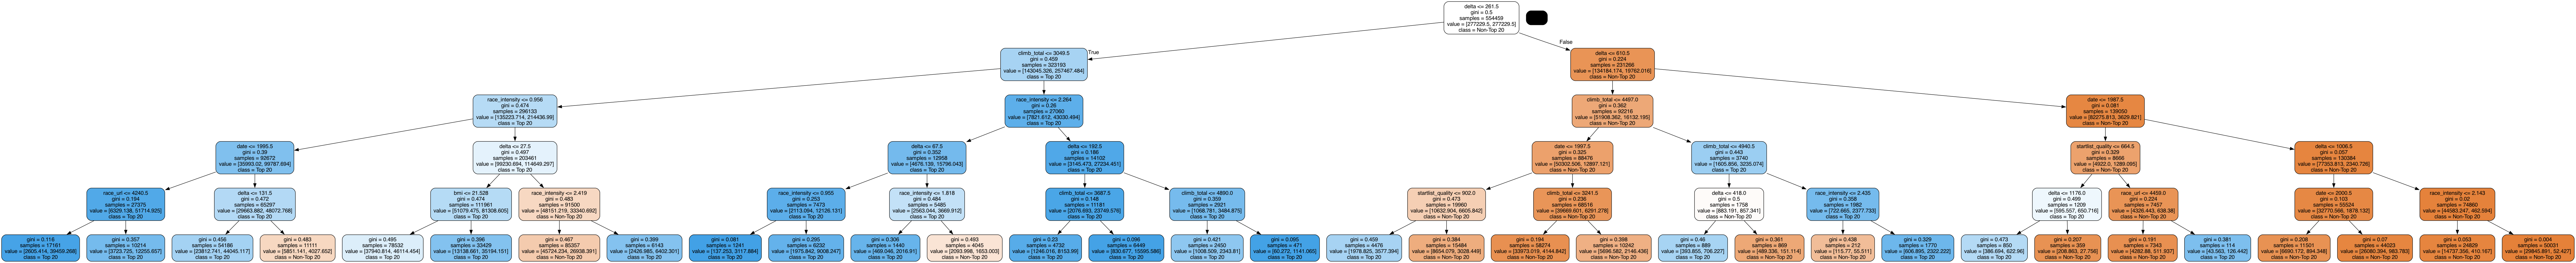

In [55]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=list(x_train.columns),  
                                class_names=['Non-Top 20', 'Top 20'],  
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


In [56]:
#Prediction over test dataset employing Decision Tree
test_pred_dt = dt.predict(x_test)    

#Compute the performance of the model
report_scores(y_test, test_pred_dt)

              precision    recall  f1-score   support

  Non-Top 20       0.95      0.75      0.84     30466
      Top 20       0.33      0.77      0.46      4940

    accuracy                           0.75     35406
   macro avg       0.64      0.76      0.65     35406
weighted avg       0.87      0.75      0.79     35406



How to read the result:
- **Non-Top 20**: 
    - Precision: 0.95 - Of all the predictions that the model classified as ‘Non-Top 20’, 95% were correct.
    - Recall: 0.75: 75% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.84 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.33 - Of all predictions classified as ‘Top 20’, only 33% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.77 - 77% of the cyclists actually in the ‘Top 20’ were recognised correctly. 
    - F1-Score: 0.46 - Being the balance between precision and recall, the mid-low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.75 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.64 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.76 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.65 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.87 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.75 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.79 - Weighted average of the F1-Score.

Confusion Matrix:
[[22794  7672]
 [ 1132  3808]]


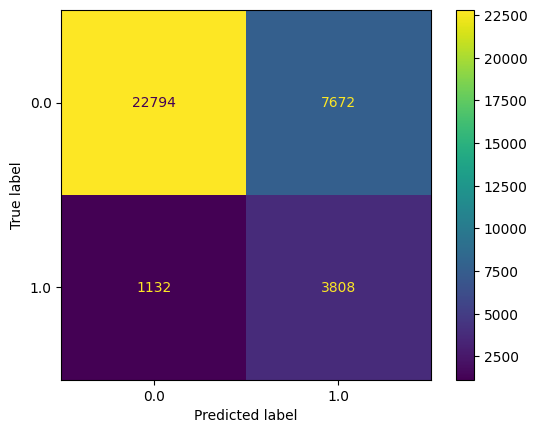

In [57]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_dt)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 22794 - Correct predictions for class 0.

- False Positives (FP): 7672 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 1132 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 3808 - Correct predictions for class 1.

### Random Forest Model

In [ ]:
#Random Forest definition and training
rf = RandomForestClassifier(
    n_estimators=100, #Number of trees in the forest
    criterion='gini', #Measure to evaluate the purity of the split
    class_weight='balanced', #Automatically calculates inverse weights to class frequencies (The class with fewer samples receives a higher weight)
    random_state=42
    max_depth=10, #Maximum depth of trees
    min_samples_split=5, #Minimum number of samples to split a node
    random_state=42, #Ensures repeatability of results
)

#Model training
rf = rf.fit(x_train, y_train)

/Users/papple/Desktop/Unipi/Esami/DATAMINING/dm_project24_group_4/env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [52]:
#Prediction employing Random Forest
test_pred_rf = rf.predict(x_test)    

#Compute the performance of the model
report_scores(y_test, test_pred_rf)

              precision    recall  f1-score   support

  Non-Top 20       0.96      0.81      0.88     30466
      Top 20       0.40      0.79      0.53      4940

    accuracy                           0.81     35406
   macro avg       0.68      0.80      0.71     35406
weighted avg       0.88      0.81      0.83     35406



How to read the result:
- **Non-Top 20**: 
    - Precision: 0.96 - Of all the predictions that the model classified as ‘Non-Top 20’, 88% were correct.
    - Recall: 0.81: 81% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.88 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.40 - Of all predictions classified as ‘Top 20’, only 40% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.79 - 79% of the cyclists actually in the ‘Top 20’ were recognised correctly. 
    - F1-Score: 0.53 - Being the balance between precision and recall, the mid-low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.81 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.68 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.80 - Arithmetic mean of the recall of the two classes. 
    - F1-Score: 0.71 - Arithmetic mean of the F1-Score of the two classes. 
- **Weighted Average**.
    - Precision: 0.88 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.81 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.83 - Weighted average of the F1-Score.

Confusion Matrix:
[[24684  5782]
 [ 1042  3898]]


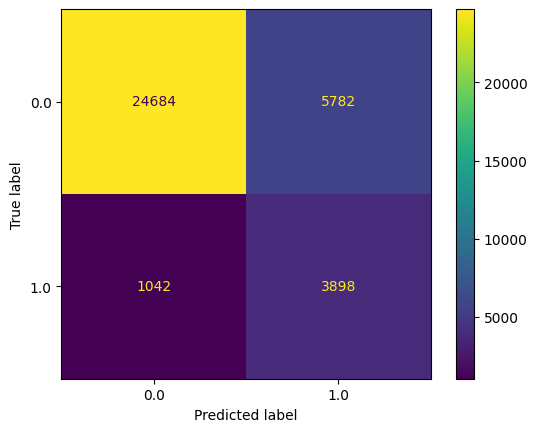

In [58]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_rf)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 24684 - Correct predictions for class 0.

- False Positives (FP): 5782 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 1042 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 3898 - Correct predictions for class 1.

### Final comparisons


In [59]:
#Dictionary containing trained models
models = {
    "Decision Tree": dt,          
    "Random Forest": rf   
}

#Iteration on models to calculate and print metrics
for model_name, model in models.items():
    y_test_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_test_pred)
    conf = confusion_matrix(y_test, y_test_pred)
    report = classification_report(y_test, y_test_pred, target_names=["Non Top 20", "Top 20"], zero_division=0)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Confusion Matrix:\n{conf}")
    print(f"Classification Report:\n{report}")



--- Decision Tree ---
Accuracy: 0.7513
Confusion Matrix:
[[22794  7672]
 [ 1132  3808]]
Classification Report:
              precision    recall  f1-score   support

  Non Top 20       0.95      0.75      0.84     30466
      Top 20       0.33      0.77      0.46      4940

    accuracy                           0.75     35406
   macro avg       0.64      0.76      0.65     35406
weighted avg       0.87      0.75      0.79     35406


--- Random Forest ---
Accuracy: 0.8073
Confusion Matrix:
[[24684  5782]
 [ 1042  3898]]
Classification Report:
              precision    recall  f1-score   support

  Non Top 20       0.96      0.81      0.88     30466
      Top 20       0.40      0.79      0.53      4940

    accuracy                           0.81     35406
   macro avg       0.68      0.80      0.71     35406
weighted avg       0.88      0.81      0.83     35406



## AdaBoost

In [60]:
# Train AdaBoost with default settings

clf = AdaBoostClassifier()
clf.fit(x_train, y_train)
test_pred_clf = clf.predict(x_test)
print(classification_report(y_test, test_pred_clf, target_names=['Non-Top 20', 'Top 20']))

/Users/papple/Desktop/Unipi/Esami/DATAMINING/dm_project24_group_4/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/papple/Desktop/Unipi/Esami/DATAMINING/dm_project24_group_4/env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

  Non-Top 20       0.88      0.98      0.93     30466
      Top 20       0.63      0.19      0.29      4940

    accuracy                           0.87     35406
   macro avg       0.75      0.58      0.61     35406
weighted avg       0.85      0.87      0.84     35406



How to read the result:
- **Non-Top 20**: 
    - Precision: 0.88 - Of all the predictions that the model classified as ‘Non-Top 20’, 88% were correct.
    - Recall: 0.98: 98% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.93 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.63 - Of all predictions classified as ‘Top 20’, only 63% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.19 - Only 19% of the cyclists actually in the ‘Top 20’ were recognised correctly. This indicates that the model is not effective in capturing true positives in this class.
    - F1-Score: 0.29 - Being the balance between precision and recall, the low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.87 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.75 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.58 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.61 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.87 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.87 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.84 - Weighted average of the F1-Score.

Confusion Matrix:
[[29909   557]
 [ 4011   929]]


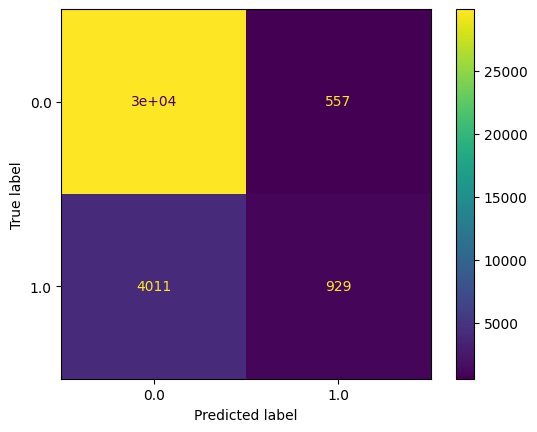

In [61]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_clf)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 29909 - Correct predictions for class 0.

- False Positives (FP): 557 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 4011 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 929 - Correct predictions for class 1.

In [62]:
# Train AdaBoost with a custom base estimator and hyperparameters

base = DecisionTreeClassifier(max_depth=5)
clf = AdaBoostClassifier(estimator=base, n_estimators=200, learning_rate=0.1)
clf.fit(x_train, y_train)
test_pred_clf = clf.predict(x_test)
print("Custom AdaBoost Classifier with DecisionTree base:")
print(classification_report(y_test, test_pred_clf, target_names=['Non-Top 20', 'Top 20']))

/Users/papple/Desktop/Unipi/Esami/DATAMINING/dm_project24_group_4/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/papple/Desktop/Unipi/Esami/DATAMINING/dm_project24_group_4/env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Custom AdaBoost Classifier with DecisionTree base:
              precision    recall  f1-score   support

  Non-Top 20       0.92      0.95      0.93     30466
      Top 20       0.59      0.47      0.52      4940

    accuracy                           0.88     35406
   macro avg       0.75      0.71      0.73     35406
weighted avg       0.87      0.88      0.87     35406



How to read the result:
- **Non-Top 20**: 
    - Precision: 0.92 - Of all the predictions that the model classified as ‘Non-Top 20’, 92% were correct.
    - Recall: 0.95: 95% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.93 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.59 - Of all predictions classified as ‘Top 20’, only 59% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.47 - Only 47% of the cyclists actually in the ‘Top 20’ were recognised correctly. 
    - F1-Score: 0.52 - Being the balance between precision and recall, the low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.88 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.75 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.71 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.73 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.87 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.88 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.87 - Weighted average of the F1-Score.

Confusion Matrix:
[[28804  1662]
 [ 2594  2346]]


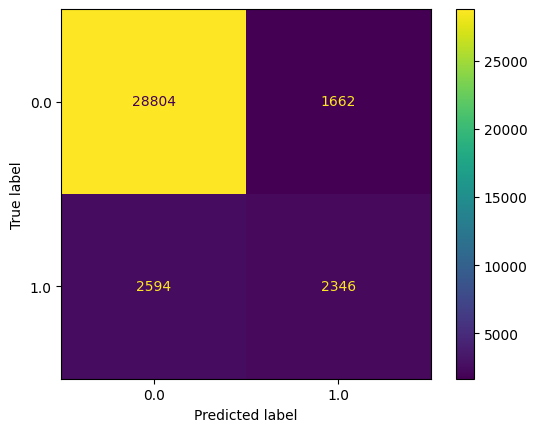

In [63]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_clf)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 28804 - Correct predictions for class 0.

- False Positives (FP): 1662 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 2594 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 2346 - Correct predictions for class 1.

## Naïve Bayes

Naive Bayes is a probabilistic machine learning algorithm based on Bayes' theorem. 

The algorithm assumes that the features are independent of each other, a simplification that is rarely true in real-world scenarios but often works well in practice. Naive Bayes calculates the probability of a data point belonging to a particular class by considering the prior probability of the class and the likelihood of the features given the class. 

The "naive" assumption of feature independence allows the algorithm to be computationally efficient and easy to implement. 

Gaussian Naive Bayes, a common variant, assumes that the features follow a Gaussian (normal) distribution and is particularly suited for continuous data. 

In [26]:
# Naïve Bayes training
gnb = GaussianNB()
gnb.fit(x_train, y_train)  

#Prediction employing Naive Bayes
test_pred_gnb = gnb.predict(x_test)  

#Compute the performance of the model
report_scores(y_test, test_pred_gnb)


              precision    recall  f1-score   support

  Non-Top 20       0.88      0.88      0.88     30466
      Top 20       0.24      0.23      0.23      4940

    accuracy                           0.79     35406
   macro avg       0.56      0.56      0.56     35406
weighted avg       0.79      0.79      0.79     35406



How to read the result:
- **Non-Top 20**: 
    - Precision: 0.88 - Of all the predictions that the model classified as ‘Non-Top 20’, 88% were correct.
    - Recall: 0.88: 88% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.88 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.24 - Of all predictions classified as ‘Top 20’, only 33% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.23 - 77% of the cyclists actually in the ‘Top 20’ were recognised correctly. 
    - F1-Score: 0.23 - Being the balance between precision and recall, the mid-low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.79 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.56 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.56 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.56 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.79 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.79 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.79 - Weighted average of the F1-Score.

Confusion Matrix:
[[26782  3684]
 [ 3795  1145]]


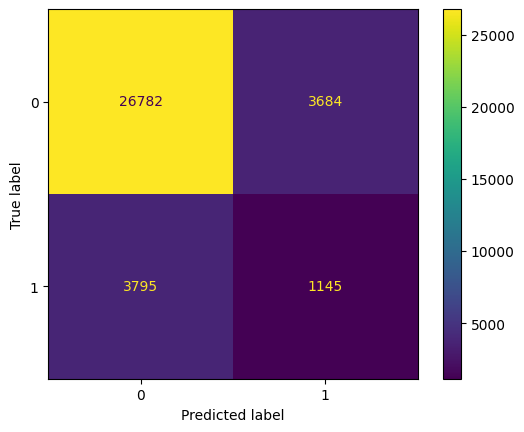

In [27]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_gnb)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 26782 - Correct predictions for class 0.

- False Positives (FP): 3684 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 3795 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 1145 - Correct predictions for class 1.

## K-Nearest Neighbors (KNN)

n_neighbors=3: Considera i 3 vicini più prossimi per classificare un nuovo campione.
algorithm='ball_tree': Algoritmo che ottimizza la ricerca dei vicini più prossimi.
metric='minkowski': Misura la distanza Euclidea tra campioni.

In [28]:
#Definition of KNN model with 3 neighbours and ‘ball_tree’ algorithm
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric='minkowski')

#Train KNN on the training data
knn.fit(x_train, y_train) 

#Prediction
test_pred_knn = knn.predict(x_test)    # Predictions on the test set

#Compute the performance of the model
report_scores(y_test, test_pred_knn)


              precision    recall  f1-score   support

  Non-Top 20       0.90      0.86      0.88     30466
      Top 20       0.30      0.38      0.34      4940

    accuracy                           0.79     35406
   macro avg       0.60      0.62      0.61     35406
weighted avg       0.81      0.79      0.80     35406



How to read the result:
- **Non-Top 20**: 
    - Precision: 0.90 - Of all the predictions that the model classified as ‘Non-Top 20’, 90% were correct.
    - Recall: 0.86: 86% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.88 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.30 - Of all predictions classified as ‘Top 20’, only 63% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.38 - Only 38% of the cyclists actually in the ‘Top 20’ were recognised correctly. This indicates that the model is not effective in capturing true positives in this class.
    - F1-Score: 0.34 - Being the balance between precision and recall, the low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.79 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.60 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.62 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.61 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.81 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.79 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.80 - Weighted average of the F1-Score.

Confusion Matrix:
[[26211  4255]
 [ 3075  1865]]


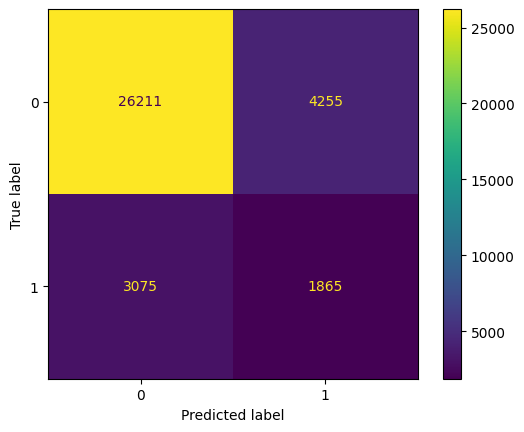

In [29]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_knn)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 26211 - Correct predictions for class 0.

- False Positives (FP): 4255 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 3075 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 1865 - Correct predictions for class 1.

## Neural Network

In [30]:
from sklearn.utils.class_weight import compute_class_weight

# Calcolo dei pesi delle classi bilanciati
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.flatten()),  # Classi presenti nei dati di training
    y=y_train.flatten()  # Flatten dei valori target
)

# Conversione in dizionario {classe: peso}
class_weight_dict = dict(enumerate(class_weights))

# Compilazione del modello
model.compile(optimizer='adamax',                       # Adam optimizer
              loss='binary_crossentropy',              # Binary cross-entropy per classificazione binaria
              metrics=['accuracy'])                    # Metriche durante il training

# Addestramento del modello con class weights
history = model.fit(
    x_train, y_train,                 # Training data
    epochs=80,                        # Number of training epochs
    batch_size=256,                   # Batch size
    validation_split=0.2,             # Validation split
    class_weight=class_weight_dict    # Bilanciamento delle classi
)


Epoch 1/80


/Users/papple/Desktop/Unipi/Esami/DATAMINING/dm_project24_group_4/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1733/1733 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8368 - loss: 0.1632 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 2/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8387 - loss: 0.1613 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 3/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8410 - loss: 0.1590 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 4/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8385 - loss: 0.1615 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 5/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8403 - loss: 0.1597 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 6/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8404 - loss: 0.1596 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 7/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8403 - loss: 0.1597 - val_accuracy: 0.8302 - val_loss: 0.1698
Epoch 8/80
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8380 - loss: 0.1620 - val_accurac

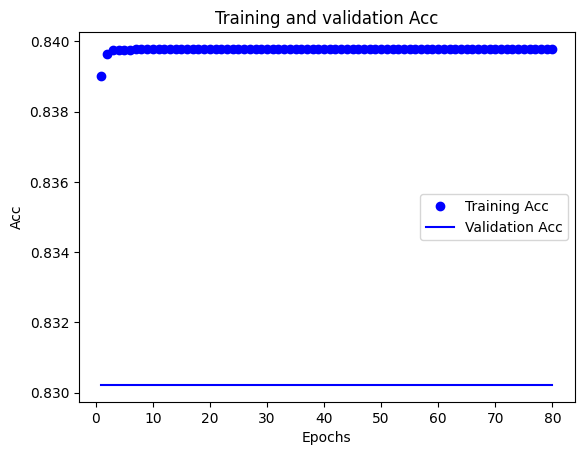

In [64]:
# Plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [65]:
# Make predictions
test_pred_proba = model.predict(x_test)
test_pred = (test_pred_proba > 0.5).astype('int32')

#Compute the performance of the model
report_scores(y_test, test_pred)


              precision    recall  f1-score   support

  Non-Top 20       0.96      0.81      0.88     30466
      Top 20       0.40      0.79      0.53      4940

    accuracy                           0.81     35406
   macro avg       0.68      0.80      0.71     35406
weighted avg       0.88      0.81      0.83     35406



How to read the result:
- **Non-Top 20**: 
    - Precision: 0.96 - Of all the predictions that the model classified as ‘Non-Top 20’, 96% were correct.
    - Recall: 0.81: 81% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.88 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.40 - Of all predictions classified as ‘Top 20’, only 40% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.79 - Only 79% of the cyclists actually in the ‘Top 20’ were recognised correctly. This indicates that the model is not effective in capturing true positives in this class.
    - F1-Score: 0.53 - Being the balance between precision and recall, the low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.81 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.68 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.80 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.71 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.88 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.81 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.83 - Weighted average of the F1-Score.

Confusion Matrix:
[[24684  5782]
 [ 1042  3898]]


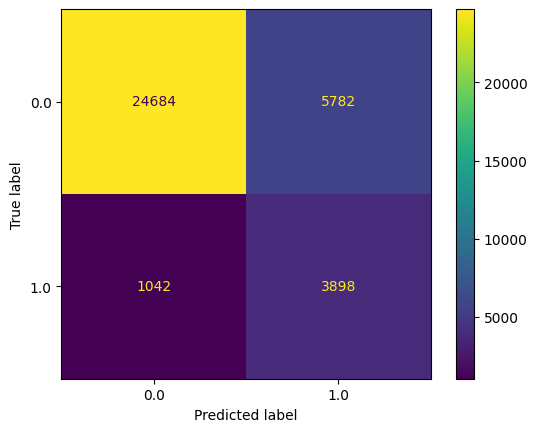

In [66]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_proba)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 24684 - Correct predictions for class 0.

- False Positives (FP): 5782 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 1042 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 3898 - Correct predictions for class 1.

## Comparison between all models

- **ROC curve**: Displays the relationship between the True Positive Rate and the False Positive Rate. A curve closer to the upper left corner indicates better performance.

- **AUC (Area Under Curve)**: A higher AUC value indicates a better predictive ability of the model. The maximum value is 1 (perfect classifier), while 0.5 indicates a random model.

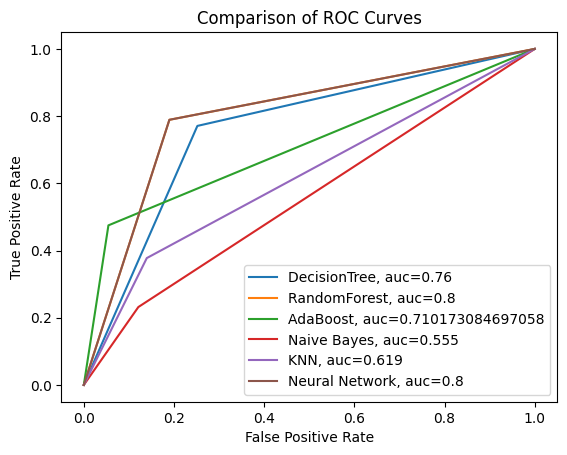

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(0).clf()  # Clear the current figure

# Decision Tree
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_dt)
auc = metrics.roc_auc_score(y_test, test_pred_dt)
plt.plot(fpr, tpr, label="DecisionTree, auc=" + str(round(auc, 3)))

# Random Forest
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_rf)
auc = metrics.roc_auc_score(y_test, test_pred_rf)
plt.plot(fpr, tpr, label="RandomForest, auc=" + str(round(auc, 3)))

# AdaBoost
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_clf)
auc = metrics.roc_auc_score(y_test, test_pred_clf)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

# Naive Bayes
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_gnb)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr, tpr, label="Naive Bayes, auc=" + str(round(auc, 3)))


# K-Nearest Neighbor
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_knn)
auc = metrics.roc_auc_score(y_test, test_pred_knn)
plt.plot(fpr, tpr, label="KNN, auc=" + str(round(auc, 3)))

# Neural Network
test_pred_nn = model.predict(x_test).ravel()  # Predict probabilities for Neural Network
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_nn)
auc = metrics.roc_auc_score(y_test, test_pred_nn)
plt.plot(fpr, tpr, label="Neural Network, auc=" + str(round(auc, 3)))

# Layout
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc=0)
plt.show()
